In [70]:
# Stylianos Topalidis
# AEM: 9613
# email: styltopa@ece.auth.gr 

In [75]:
# Note: Please run the cells sequentially as some of them
# require the execution of previous ones to run as expected

# Libraries imports
import numpy as np
import matplotlib.pyplot as plt
import random 

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
# if the import below does not work please try opening a terminal and writing 
# pip install -U scikit-learn --user
# This worked for me (at least in vscode).
# There is some discourse in the forum that it does not work in collab
# see https://stackoverflow.com/questions/72246343/importerror-cannot-import-name-decisionboundarydisplay-from-sklearn-inspecti
from sklearn.metrics import accuracy_score

# Print the cell outputs
import tabulate
from IPython.display import HTML, display



# Part A

# Load data
iris = load_iris()

# Percentage of the data for the training 
trainPercent = 0.5

# Exclude duplicates of target values using set (multiple 0, 1 and 2)
# Turn the set into a list and then into a numpy array
# for convenience 
targetArr = np.array(list(set(iris.target)))


# - indsPerKind: Indexes per flower kind in iris.data (iterates over the
#  different targets: setosa, versicolor, virginica) 
# - trainingInds, testingInds: Indexes for the training and
#  testing data in the original dataset. 
indsPerKind = []
trainingInds = []
testingInds = []

# For each flower kind
for targetCount in range(len(targetArr)):

    # Only the first element of the returned array is the actual indexes  
    indsPerKind = list(np.where(iris.target == targetCount)[0]) 
    
    # number of training data derived from the training percentage selected
    # per group kind (0, 1, 2)
    numOfTrainingDataPerKind = round(trainPercent*len(indsPerKind))
    numOfTestingDataPerKind = len(indsPerKind) - numOfTrainingDataPerKind

    # Concatenate the indexes of the new target (kind) training data 
    # with the indexes of the old target training data
    trainingInds = trainingInds + indsPerKind[0:numOfTrainingDataPerKind]
    testingInds = testingInds + indsPerKind[numOfTrainingDataPerKind:]
    

# list -> np.array
trainingInds = np.array(trainingInds)
testingInds = np.array(testingInds)


# rnd: A seed used for the permutation of the training data
# and also for the classifiers themselves in the "random_state" parameter
# for both the DecisionTreeClassifier and the RandomForestClassifier

# # Uncomment this section to yield different results with each execution,
# # comment the section right after this one. 
# randStart = 0
# randStop = 10000
# rnd  = np.random.randint(randStart, randStop)

# # For reproducibility of the results
rnd = 0
np.random.seed(rnd)

# To avoid training the tree with batches of data of the same target,
# as given (all setosa first, then all versicolor and finally all virginica),
# we permute the training data .
trainingIndsPerm =  np.random.permutation(trainingInds)


# Training data and target values
trainingArr = iris.data[trainingIndsPerm, 0:2]
targetArrTraining = iris.target[trainingIndsPerm]

# Testing data and target values
testingArr = iris.data[testingInds, 0:2]
targetArrTesting = iris.target[testingInds]

# List with the accuracies of all decision tree classifiers per depth of tree
accList = list()

numOfTrainingData = len(targetArr)*numOfTrainingDataPerKind


# A.1

print('Decision Tree Classifier')

# Different depths of the decision tree classifier
treeDepths = np.array([1, 2, 3, 4, 5, 6])

# Train classifier per depth
for depthCount, depth in enumerate(treeDepths):
    # Classifier training
    clf = DecisionTreeClassifier(max_depth=depth, random_state = rnd)
    clf = clf.fit(trainingArr, targetArrTraining)
    
    # Classifier predictions of the targets
    targetArrPred = clf.predict(testingArr)

    accuracy = accuracy_score(targetArrTesting, targetArrPred)
    accList.append([str(depth), str(round(100*accuracy, 1))])

    # Find the classifier with the best accuracy to plot in part A.2
    if depth == treeDepths[0]:
        maxAccClf = clf
        maxAcc = accuracy
    if maxAcc < accuracy:
        maxAccClf = clf
        maxAcc = accuracy

print('----------------------------------'
    '\nMax accuracy classifier is the one with depth = ',
    maxAccClf.tree_.max_depth, 
    'and accuracy: ', round(100*maxAcc, 2), '%')


# Plot the accuracies of the classifiers per tree depth
table = tabulate.tabulate(accList, tablefmt='html', 
    headers=["Decision Tree depth", "Accuracy (%)"])
display(HTML(table))

# Remarks:
# 1) Randomness of the training:
# If the parameter "random_state" of the decision tree classifier object is not
# explicitly specified, the classifier derived from
# the training is different for consecutive trainings.
# 
# For convenience of the analysis, we set the random_state parameter equal to
# a fixed value (0 in my case).
# Unless this is a fixed value, the classifier derived is different for consecutive 
# executions, 
# and so are different the depth giving the best accuracy and the accuracy itself.
# Therefore, all remarks and points made from now on are based on the fact that
# random_state = 0. For different random_state values, the results differ.


# 2)
# I will refer to the percentage of correct predictions 
# in the testing set as accuracy.
# The accuracy achieved is 80% (see cell output).
# The depth of the decision tree classifier giving the highest
# accuracy is 4 (see cell output). For different values of 
# the random seed the accuracy and the depth might be
# slightly different. 


Decision Tree Classifier
----------------------------------
Max accuracy classifier is the one with depth =  4 and accuracy:  80.0 %


Decision Tree depth,Accuracy (%)
1,64
2,68
3,69.3
4,80
5,80
6,80


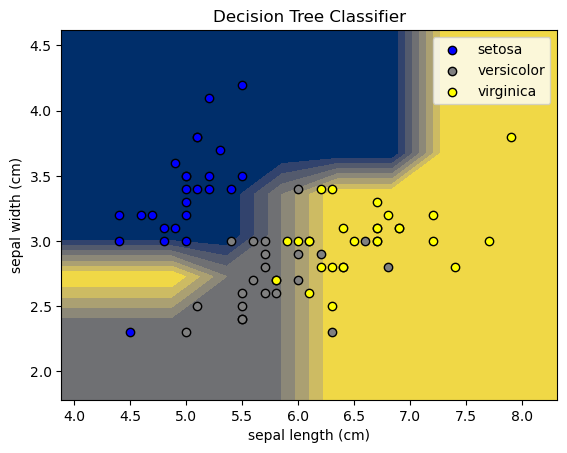

In [76]:
# A.2
# Plot the decision boundaries of the classifier with the best accuracy
# found from A.1

stdVal = np.zeros((2,))
minBound = np.zeros((2,))
maxBound = np.zeros((2,))
numOfPointsInMesh = 10
space = np.zeros((numOfPointsInMesh, 2))

# bounds for the meshgrid
# coord = 0 for length and = 1 for width
for coord in range(0, 2):
    stdVal[coord] = np.std(iris.data[:, coord])
    minBound[coord] = np.min(iris.data[:, coord]) - stdVal[coord]/2
    maxBound[coord] = np.max(iris.data[:, coord]) + stdVal[coord]/2
    space[:, coord] = np.linspace(minBound[coord], maxBound[coord], numOfPointsInMesh)

# X is the sepal length and Y the sepal width space
X, Y = np.meshgrid(space[:, 0], space[:, 1])

Z = np.zeros_like(X)


for y in range(numOfPointsInMesh):
    valToPredict = np.stack((X[:, y], Y[:, y]), axis = 1)
    Z[:, y] = maxAccClf.predict(valToPredict)

fig, ax = plt.subplots()
c  = ['blue', 'grey', 'yellow'] 
CS = ax.contourf(X, Y, Z, cmap=plt.cm.cividis)
ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.set_title("Decision Tree Classifier")

# Multiple scatter diagrams, one per kind of flower
for i, t in enumerate(targetArr):
    targetInds = np.where(targetArrTesting == t)
    plt.scatter(
        testingArr[targetInds, 0], testingArr[targetInds, 1], color = c[i],
        edgecolor="black", label =  iris.target_names[i] 
    )

plt.legend()

# Remarks
# 1) 
# The decision boundaries derived from the simple decision tree classifier
# is not complex (see cell output). They are more defined as the number of 
# training data samples increases (variable numOfPointsInMesh).

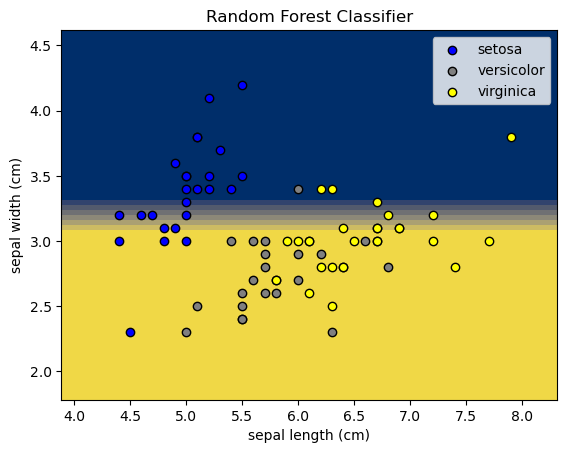

In [79]:
# Part B
# B.2

B = 150
gamma = 0.5
bootSamSize = round(gamma*numOfTrainingData)
clfList = []
votingList  = []
Z = np.zeros_like(X)
votingArr = np.empty((0, 1))

np.random.seed(0)

# Training of the trees in the forest
for treeCount in range(B):
    # boostrap sampling
    bootIndexes = np.random.randint(0, len(targetArr), bootSamSize)
    bootSam = trainingArr[bootIndexes]
    bootSamTarget = targetArrTraining[bootIndexes]
    # training using the depth deriving the best accuracy in 
    # the simple decision tree classifier of the previous part (A)
    # (note: more max depths of the trees in the random forest 
    # were not covered in this project.)
    clf = DecisionTreeClassifier(max_depth=maxAccClf.tree_.max_depth, random_state = None)
    clf = clf.fit(bootSam, bootSamTarget)
    clfList.append(clf)

# For every point in the mess
for x in range(numOfPointsInMesh):    
    for y in range(numOfPointsInMesh):
        valToPredict = np.stack((X[x, y], Y[x, y]))
        valToPredictReshaped = valToPredict.reshape(1, -1)
        votinglist = []
        # Voting of the trees per point in the meshgrid
        for treeCount in range(B):
            vote = clfList[treeCount].predict(valToPredictReshaped)
            votingList.append(vote)
        votingArr = np.array(votingList)
        del votingList[:]
        maxVotes = 0
        # classCode is 0, 1 or 2 for setosa, versicolor 
        # and virginica respectively
        for classCode in range(len(targetArr)):
            if maxVotes < np.count_nonzero(votingArr == classCode):
                maxVotes = np.count_nonzero(votingArr == classCode)
                # final committee decision for the point
                Z[x, y] = classCode

# Plot the random forest classifier decision boundaries 
fig, ax = plt.subplots()
c  = ['blue', 'grey', 'yellow'] 
CS = ax.contourf(X, Y, Z, cmap=plt.cm.cividis)
ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.set_title("Random Forest Classifier")

# Multiple scatter diagrams, one per kind of flower
for i, t in enumerate(targetArr):
    targetInds = np.where(targetArrTesting == t)
    plt.scatter(
        testingArr[targetInds, 0], testingArr[targetInds, 1], color = c[i],
        edgecolor="black", label =  iris.target_names[i] 
    )

plt.legend()

# Remarks
# 1) The decision boundaries of the Random Forest Classifier 
# are not plotted correctly. 
# However, I still want to showcase the idea behind the voting 
# of the points in the meshgrid so that areas of points classified in 
# the same way are formed.
# 2) Also, for different random seeds, the decision boundaries differ.

# The accuracy of the random forest classifier and the accuracy for 
# as a function of gamma is not covered in this project.  